Test with Acropora abrolhosensis https://www.marinespecies.org/aphia.php?p=taxdetails&id=288182
aphiaID = 288182  
urn = urn:lsid:marinespecies.org:taxname:288182

In [ ]:
import json
from urllib.request import urlopen
import pandas as pd

In [3]:
base = 'https://api.obis.org/v3/'

aphiaID = '288182'

occurrence_id = 'occurrence?taxonid={}'.format(aphiaID)

#taxon_id = 'taxon/{}'.format(aphiaID)
#taxon_sn = 'taxon/{}'.format(scientificname)

url = '{}{}'.format(base,occurrence_id)

url

'https://api.obis.org/v3/occurrence?taxonid=288182'

In [20]:
response= urlopen(url)

data_json = json.loads(response.read())
data_json['results']

data = pd.DataFrame(data_json['results'])
data.head()

,brackish,scientificNameID,scientificName,absence,dropped,genusid,aphiaID,decimalLatitude,subclassid,originalScientificName,...,organismQuantityType,scientificNameAuthorship,fieldNumber,language,datasetName,geodeticDatum,waterBody,occurrenceRemarks,locality,country
0,False,urn:lsid:marinespecies.org:taxname:288182,Acropora abrolhosensis,False,False,205469,288182,-20.530001,1340,Acropora abrolhosensis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,urn:lsid:marinespecies.org:taxname:288182,Acropora abrolhosensis,False,False,205469,288182,-8.616660,1340,Acropora abrolhosensis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,urn:lsid:marinespecies.org:taxname:288182,Acropora abrolhosensis,False,False,205469,288182,-28.730000,1340,Acropora abrolhosensis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,urn:lsid:marinespecies.org:taxname:288182,Acropora abrolhosensis,False,False,205469,288182,-17.200000,1340,Acropora abrolhosensis,...,individuals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,urn:lsid:marinespecies.org:taxname:288182,Acropora abrolhosensis,False,False,205469,288182,-0.500000,1340,Acropora abrolhosensis,...,NaN,"Veron, 1985",2506140,en,South Pacific Regional Fisheries Management Or...,WGS84,Pacific Ocean,VME Group = Scleractinia; Source = OBIS Hexaco...,NaN,NaN


<AxesSubplot:>

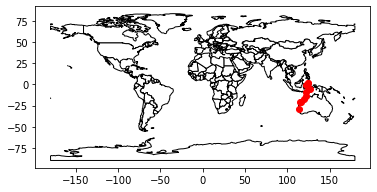

In [9]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude))

ax = world.plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

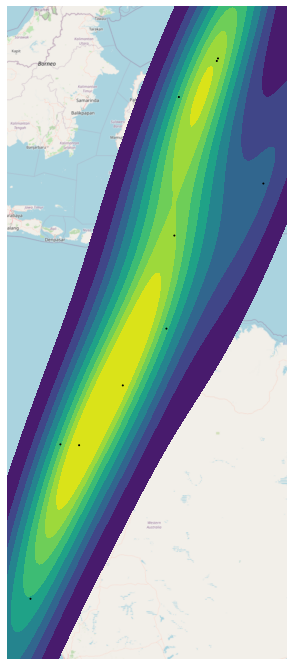

In [19]:
import geoplot

ax = geoplot.kdeplot(
    gdf,
    shade=True, 
    cmap='viridis',
    projection=geoplot.crs.WebMercator(),
    figsize=(12,12),
    )

geoplot.pointplot(gdf, s=1, color='black', ax=ax)
geoplot.webmap(gdf, ax=ax, legend=True)

#geoplot.polyplot(gdf, ax=ax, zorder=1)

Now try for searching the order [Scleractinia](https://www.marinespecies.org/aphia.php?p=taxdetails&id=1363) and drill down to all species. 

**AphiaID** 1363  (urn:lsid:marinespecies.org:taxname:1363) 

Use WoRMS REST service
https://www.marinespecies.org/rest/ and test for one search

In [31]:
base = 'https://www.marinespecies.org/rest/'

aphiaID = '1363'

aphia_childs = 'AphiaChildrenByAphiaID/{}'.format(aphiaID) # get all children

offset = 1 # Starting recordnumber, when retrieving next chunk of (50) records. Default=1

worms_url = '{}{}?marine_only=true&offset={}'.format(base,aphia_childs,offset)

worms_url

'https://www.marinespecies.org/rest/AphiaChildrenByAphiaID/1363?marine_only=true&offset=1'

The service only provides 50 records, so we need to iterate by 50 until we get less than 50 responses

In [55]:
worms_df = pd.DataFrame()

for i in range(1,100000,50):
    offset = i
    worms_url = '{}{}?marine_only=true&offset={}'.format(base,aphia_childs,offset)
    response = urlopen(worms_url)
    data_json = json.loads(response.read())
    worms_df = pd.concat([worms_df,pd.DataFrame(data_json)])
    if len(data_json) < 50:
        break

        
worms_df = worms_df[worms_df['rank']=='Family']    # only use family 

worms_df.shape

(189, 27)

Now look for each aphia ID in OBIS and build a mongo data frame.

In [56]:
base = 'https://api.obis.org/v3/'

data = pd.DataFrame()

for aphiaID in worms_df['AphiaID']:

    occurrence_id = 'occurrence?taxonid={}'.format(aphiaID)
    url = '{}{}'.format(base,occurrence_id)
    response= urlopen(url)
    data_json = json.loads(response.read())
    data_json['results']
    data = pd.concat([data, pd.DataFrame(data_json['results'])])
    #data.head()

data.describe()

,date_year,genusid,aphiaID,decimalLatitude,subclassid,phylumid,familyid,date_mid,orderid,decimalLongitude,...,shoredistance,sst,bathymetry,speciesid,minimumDepthInMeters,maximumDepthInMeters,depth,subgenusid,subspeciesid,subfamilyid
count,301.000000,4.170000e+02,4.170000e+02,417.000000,417.0,417.0,4.170000e+02,3.010000e+02,417.0,417.000000,...,4.170000e+02,386.000000,417.000000,3.610000e+02,280.000000,275.000000,281.000000,17.000000,3.000000,20.000000
mean,1991.734219,3.555494e+05,4.135435e+05,2.340429,1340.0,1267.0,5.288260e+05,7.018306e+11,1363.0,25.177510,...,2.763485e+04,25.352617,234.127194,4.096589e+05,191.442133,207.604834,199.463571,509431.705882,287363.333333,718677.400000
std,30.967765,3.627616e+05,3.892359e+05,22.691896,0.0,0.0,4.884185e+05,9.773600e+11,0.0,119.122849,...,1.644702e+05,4.337449,673.804389,3.761626e+05,418.525051,437.040267,424.189335,1641.510119,878.920550,5.335087
min,1775.000000,1.350850e+05,1.350870e+05,-55.533333,1340.0,1267.0,1.350730e+05,-6.137856e+12,1363.0,-178.419998,...,-5.743580e+05,-0.330000,-895.000000,1.351350e+05,0.000000,0.000000,0.000000,503252.000000,286726.000000,718667.000000
25%,1984.000000,2.041480e+05,2.072250e+05,-17.350000,1340.0,1267.0,1.960950e+05,4.495392e+11,1363.0,-79.583000,...,1.290000e+02,25.080000,-2.000000,2.073870e+05,5.000000,10.000000,8.500000,509582.000000,286862.000000,718680.000000
50%,2002.000000,2.056470e+05,2.870800e+05,6.382230,1340.0,1267.0,1.961050e+05,1.029024e+12,1363.0,46.049999,...,1.525000e+03,26.625000,16.600000,2.874440e+05,39.000000,40.000000,41.000000,510036.000000,286998.000000,718680.000000
75%,2009.000000,2.676600e+05,2.911190e+05,20.616667,1340.0,1267.0,7.185850e+05,1.253923e+12,1363.0,145.478000,...,1.615700e+04,28.120000,193.000000,2.911190e+05,275.750000,300.000000,291.500000,510037.000000,287682.000000,718680.000000
max,2019.000000,1.440307e+06,1.511284e+06,64.169998,1340.0,1267.0,1.507871e+06,1.568938e+12,1363.0,178.929993,...,2.227290e+06,29.870000,4752.770000,1.511284e+06,3978.000000,3978.000000,3978.000000,510037.000000,288366.000000,718680.000000


Now make a heatmap of all the points.

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

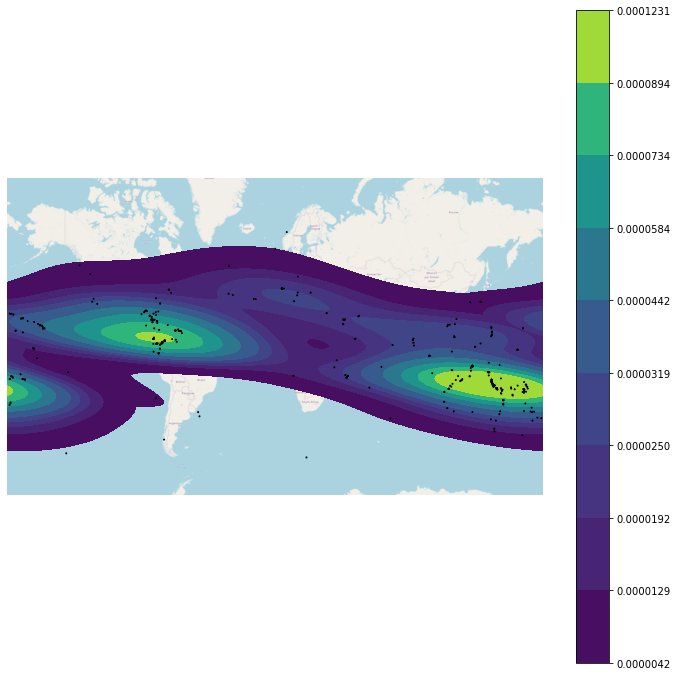

In [59]:
import geoplot

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude))

ax = geoplot.kdeplot(
    gdf,
    shade=True, 
    cmap='viridis',
    projection=geoplot.crs.WebMercator(),
    figsize=(12,12),
    cbar=True,
    )

geoplot.pointplot(gdf, s=1, color='black', ax=ax)
geoplot.webmap(gdf, ax=ax, legend=True)

## Need to mask by land so heatmap doesn't cover land.

Make a simple map

<AxesSubplot:>

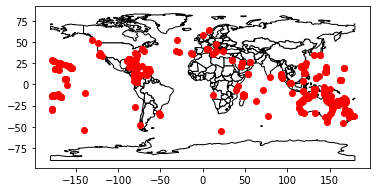

In [58]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude))

ax = world.plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')